In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


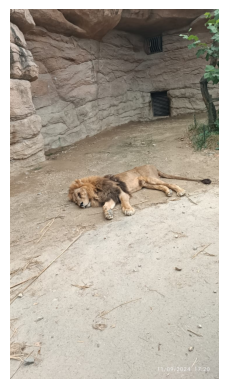

In [2]:
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.pyplot as plt
import numpy as np
with cbook.get_sample_data('/content/gdrive/MyDrive/HPC/lion.jpg') as file:
	im = image.imread(file)

fig, ax = plt.subplots()
ax.imshow(im)
ax.axis('off')

plt.show()

In [3]:
pixel_count = im.shape[0] * im.shape[1]

flattened_image = im.reshape(pixel_count, 3)

print(flattened_image.shape)
print(flattened_image[:5])


(922880, 3)
[[172 158 145]
 [161 147 134]
 [117 103  92]
 [105  91  80]
 [104  90  81]]


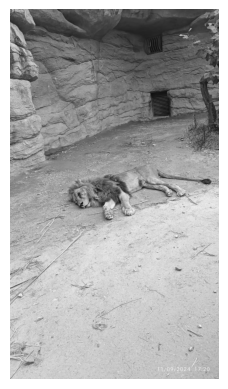

GPU time: 0.19431567192077637
CPU time: 7.146866321563721


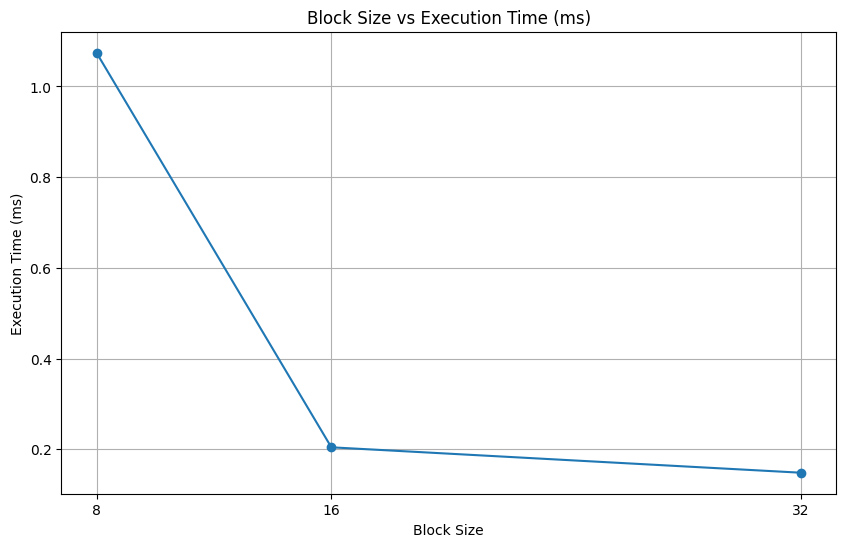

In [11]:
import numba
from numba import cuda
import numpy as np
import time
import matplotlib.pyplot as plt

@cuda.jit
def grayscale_2d(src, dst, width, height):

    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if x < width and y < height:
        tidx = y * width + x
        g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) // 3)
        dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

height, width = im.shape[0], im.shape[1]
pixel_count = height * width

devSrc = cuda.to_device(flattened_image)
devDst = cuda.device_array((pixel_count, 3), np.uint8)

block_size_x = 16
block_size_y = 16
grid_size_x = (width + (block_size_x - 1)) // block_size_x
grid_size_y = (height + (block_size_y - 1)) // block_size_y

time1 = time.time()
grayscale_2d[(grid_size_x, grid_size_y), (block_size_x, block_size_y)](devSrc, devDst, width, height)
hostDst = devDst.copy_to_host()
time2 = time.time()

grayscale_image_3d = hostDst.reshape(height, width, 3)

plt.imshow(grayscale_image_3d)
plt.axis('off')
plt.show()

gpu_time = time2 - time1
print(f"GPU time: {gpu_time}")

def convert_to_grayscale_cpu(flattened_image):
    pixel_count = flattened_image.shape[0]
    dst = np.zeros_like(flattened_image, dtype=np.uint8)

    for pixel in range(pixel_count):
        r, g, b = flattened_image[pixel].astype(np.float32)
        gray = np.uint8((r + g + b) // 3)
        dst[pixel] = [gray, gray, gray]

    return dst

time3 = time.time()
cpu_base = convert_to_grayscale_cpu(flattened_image)
time4 = time.time()

cpu_time = time4 - time3
print(f"CPU time: {cpu_time}")

block_sizes = [8, 16, 32]
execution_times = []

for block_size in block_sizes:
    block_size_x = block_size
    block_size_y = block_size

    grid_size_x = (width + block_size_x - 1) // block_size_x
    grid_size_y = (height + block_size_y - 1) // block_size_y

    device = cuda.get_current_device()

    start_time = time.time()
    grayscale_2d[(grid_size_x, grid_size_y), (block_size_x, block_size_y)](devSrc, devDst, width, height)
    cuda.synchronize()
    end_time = time.time()

    execution_time = end_time - start_time
    execution_times.append(execution_time * 1000)

plt.figure(figsize=(10, 6))
plt.plot(block_sizes, execution_times, marker='o', linestyle='-')
plt.title("Block Size vs Execution Time (ms)")
plt.xlabel("Block Size")
plt.ylabel("Execution Time (ms)")
plt.xticks(block_sizes)
plt.grid(True)
plt.show()
